In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [110]:
warnings.filterwarnings('ignore')

In [111]:
!pip install dagshub mlflow
import dagshub
import mlflow
dagshub.init(repo_owner='jgushiann', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

Initialized MLflow to track repo "jgushiann/IEEE-CIS-Fraud-Detection"

Repository jgushiann/IEEE-CIS-Fraud-Detection initialized!

In [112]:
mlflow.set_experiment("LogisticRegression_Training")

<Experiment: artifact_location='mlflow-artifacts:/8dc2236309c04f8a9a9f9d8e3a15b65e', creation_time=1745936871514, experiment_id='0', last_update_time=1745936871514, lifecycle_stage='active', name='LogisticRegression_Training', tags={}>

In [113]:
mlflow.end_run()

🏃 View run mysterious-hog-923 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/bb55d70048f9477799295e8ba8539e63
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


# **Cleaning** 

In [114]:
with mlflow.start_run(run_name="LogisticRegression_Data_Loading"):
    train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
    test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
    
    train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
    test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
    
    print(f"Train shape: {train_transaction.shape}")
    print(f"Test shape: {test_transaction.shape}")

    mlflow.log_param("train_transaction_rows", train_transaction.shape[0])
    mlflow.log_param("train_transaction_cols", train_transaction.shape[1])

Train shape: (590540, 394)
Test shape: (506691, 393)
🏃 View run LogisticRegression_Data_Loading at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/e0173ec0f8d9406e836a6c3a66ad23b1
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [115]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
with mlflow.start_run(run_name="LogisticRegression_Cleaning"):
    #protecting RAM
    def reduce_mem_usage(df, verbose=True):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2    
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
        end_mem = df.memory_usage().sum() / 1024**2
        if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        return df

🏃 View run LogisticRegression_Cleaning at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/7882e789babe41f7bdd8045d00938d54
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [117]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

print(f"Train merged shape: {train.shape}")
print(f"Test merged shape: {test.shape}")

Train merged shape: (590540, 434)
Test merged shape: (506691, 433)


In [118]:
# dropping NaN columns
missing_train = train.isnull().mean()
missing_cols = missing_train[missing_train > 0.9].index.tolist() #wasashleli

train = train.drop(columns=missing_cols)

test_cols = [col for col in missing_cols if col in test.columns]
test = test.drop(columns=test_cols)

print(f"Train shape after dropping: {train.shape}")
print(f"Test shape after dropping: {test.shape}")


Train shape after dropping: (590540, 422)
Test shape after dropping: (506691, 431)


In [119]:
# filling missing vals
for col in train.columns:
    if col == 'isFraud':
        continue
    if train[col].dtype == 'object':
        train[col] = train[col].fillna('unknown')   #categoricals
        if col in test.columns:
            test[col] = test[col].fillna('unknown')
    else:
        train[col] = train[col].fillna(-999)        #numericals
        if col in test.columns:
            test[col] = test[col].fillna(-999)

In [120]:
y_train = train['isFraud']
X_train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
X_test = test.drop(['TransactionID', 'TransactionDT'], axis=1)

In [121]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (590540, 419)
X_test shape: (506691, 429)


In [122]:
cat_cols = X_train.select_dtypes(include='object').columns

for col in cat_cols:
    le = LabelEncoder()
    
    if col in X_test.columns:
        full_data = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
        le.fit(full_data)
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    else:
        X_train[col] = le.fit_transform(X_train[col].astype(str))

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Mem. usage decreased to 507.99 Mb (73.1% reduction)
Mem. usage decreased to 502.06 Mb (69.7% reduction)


In [123]:
#logging
mlflow.log_param("initial_train_cols", train_transaction.shape[1] + train_identity.shape[1] - 1)
mlflow.log_param("final_train_cols", train.shape[1])
mlflow.log_param("dropped_cols_count", len(missing_cols))

12

# **Feature Engineering**

In [124]:
mlflow.end_run()

🏃 View run melodic-kit-675 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/79705b734f8e46a7890f7f4580bbee23
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [125]:
with mlflow.start_run(run_name="LogisticRegression_Feature_Engineering"):

    cols_incommon = X_train.columns.intersection(X_test.columns)
    X_train = X_train[cols_incommon]
    X_test = X_test[cols_incommon]
    
    if 'TransactionDT' in train.columns:
        train['hour'] = (train['TransactionDT'] / 3600) % 24
        test['hour'] = (test['TransactionDT'] / 3600) % 24
        
        train['day_of_week'] = ((train['TransactionDT'] / (3600 * 24)) % 7).astype(int)
        test['day_of_week'] = ((test['TransactionDT'] / (3600 * 24)) % 7).astype(int)
        
        X_train['hour'] = train['hour']
        X_test['hour'] = test['hour']
        X_train['day_of_week'] = train['day_of_week']
        X_test['day_of_week'] = test['day_of_week']

🏃 View run LogisticRegression_Feature_Engineering at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/d973d827679e4347b1466bf909c6dd67
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [126]:
mlflow.log_param("features_count", X_train.shape[1])

393

# **Feature Selection**

In [127]:
mlflow.end_run()

🏃 View run treasured-smelt-762 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/8b153a3a69844de8ab5a3e0406d94e7b
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [128]:
X_train_numeric = X_train.select_dtypes(include=[np.number]).fillna(0)
X_train_small = X_train_numeric.iloc[:, :100]

X_train_fs, X_val, y_train_fs, y_val = train_test_split(X_train_small, y_train, test_size=0.2, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fs)
X_val_scaled = scaler.transform(X_val)

In [129]:
with mlflow.start_run(run_name="LogisticRegression_Feature_Selection"):
    l1_model = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=500, random_state=42)

    l1_model.fit(X_train_scaled, y_train_fs)
    feature_importance = np.abs(l1_model.coef_[0])
    feature_names = X_train_fs.columns

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df.head(10))

   Feature  Importance
26     C14    0.827613
34      D9    0.682348
14      C2    0.574695
33      D8    0.501336
30      D4    0.500889
13      C1    0.499843
19      C7    0.477746
23     C11    0.433280
31      D5    0.372646
44      M4    0.330086
🏃 View run LogisticRegression_Feature_Selection at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/60a57b6fff8c4364ab579d9ab4d28275
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


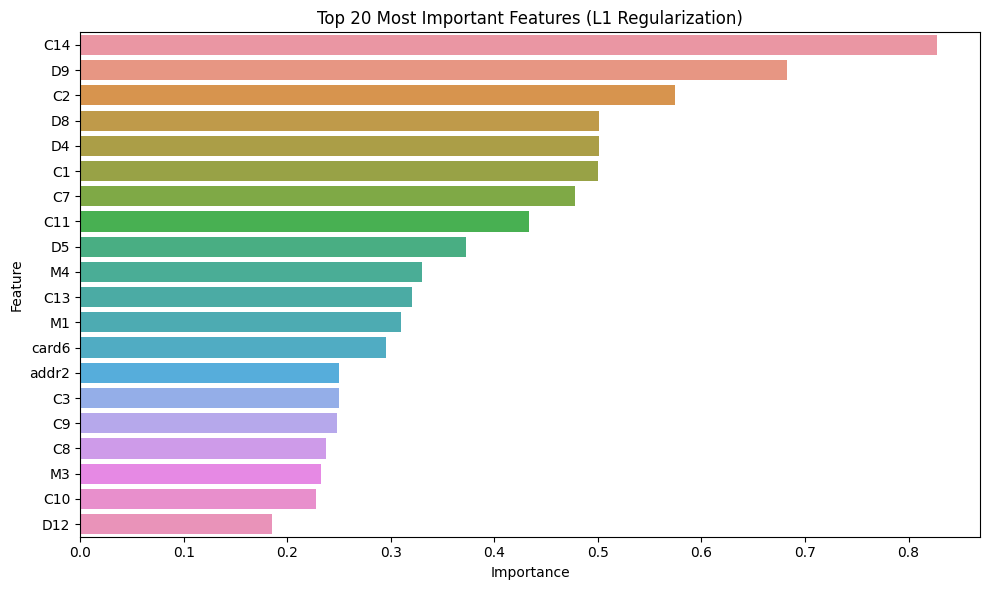

In [130]:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Most Important Features (L1 Regularization)')
    plt.tight_layout()
    plt.savefig('feature_importance_lr.png')
    mlflow.log_artifact('feature_importance_lr.png')

In [131]:
    non_zero_features = feature_importance_df[feature_importance_df['Importance'] > 0]
    top_features = non_zero_features['Feature'].head(50).values
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

In [132]:
    mlflow.log_param("total_features", len(feature_names))
    mlflow.log_param("selected_features", len(top_features))

50

In [133]:
    scaler_full = StandardScaler()
    X_val_full_scaled = scaler_full.fit_transform(X_val)
    model_full = LogisticRegression(random_state=42, max_iter=100)
    model_full.fit(X_train_scaled, y_train_fs)

LogisticRegression(random_state=42)

In [134]:
    val_score_before = roc_auc_score(y_val, model_full.predict_proba(X_val_full_scaled)[:, 1])
    
    scaler_selected = StandardScaler()
    X_train_selected_scaled = scaler_selected.fit_transform(X_train_fs[top_features])
    X_val_selected_scaled = scaler_selected.transform(X_val[top_features])
    model_selected = LogisticRegression(random_state=42, max_iter=100)
    model_selected.fit(X_train_selected_scaled, y_train_fs)
    
    val_score_after = roc_auc_score(y_val, model_selected.predict_proba(X_val_selected_scaled)[:, 1])

In [135]:
    mlflow.log_metric("val_auc_before_selection", val_score_before)
    mlflow.log_metric("val_auc_after_selection", val_score_after)
    print(f"AUC before feature selection: {val_score_before:.4f}")
    print(f"AUC after feature selection: {val_score_after:.4f}")

AUC before feature selection: 0.7981
AUC after feature selection: 0.8014


In [136]:
#cleaning-feature engineering - feature selection -training

In [137]:
mlflow.end_run()

🏃 View run receptive-horse-887 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/12a9094c270141f6baa4386456ea28b6
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0


In [138]:
import sys
print(f"Python version: {sys.version}")
# Completely remove both packages
!pip uninstall -y scikit-learn
!pip uninstall -y imbalanced-learn

# Force reinstall scikit-learn with a specific version known to be stable
!pip install --force-reinstall scikit-learn==0.24.2

# Now install a compatible imbalanced-learn version
!pip install imbalanced-learn==0.8.1

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: imbalanced-learn 0.8.1
Uninstalling imbalanced-learn-0.8.1:
  Successfully uninstalled imbalanced-learn-0.8.1
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ...   error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached imbalanced_

In [139]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report, roc_curve
)

In [140]:
def print_model_metrics(model, X_train_scaled, y_train_model, X_val_scaled, y_val, threshold=0.5):
    """
    Print comprehensive metrics for the logistic regression model
    """
    y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_train_pred = (y_train_pred_proba >= threshold).astype(int)
    
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    
    train_accuracy = accuracy_score(y_train_model, y_train_pred)
    train_precision = precision_score(y_train_model, y_train_pred)
    train_recall = recall_score(y_train_model, y_train_pred)
    train_f1 = f1_score(y_train_model, y_train_pred)
    train_auc = roc_auc_score(y_train_model, y_train_pred_proba)
    
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    val_pr_auc = auc(recall, precision)
    
    print("\n" + "="*60)
    print(f"MODEL METRICS (C={model.C}, threshold={threshold})")
    print("="*60)
    
    print("\nTraining Metrics:")
    print(f"Accuracy:  {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall:    {train_recall:.4f}")
    print(f"F1 Score:  {train_f1:.4f}")
    print(f"ROC AUC:   {train_auc:.4f}")
    
    print("\nValidation Metrics:")
    print(f"Accuracy:  {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall:    {val_recall:.4f}")
    print(f"F1 Score:  {val_f1:.4f}")
    print(f"ROC AUC:   {val_auc:.4f}")
    print(f"PR AUC:    {val_pr_auc:.4f}")
    
    print("\nTraining Confusion Matrix:")
    train_cm = confusion_matrix(y_train_model, y_train_pred)
    print(train_cm)
    
    print("\nValidation Confusion Matrix:")
    val_cm = confusion_matrix(y_val, y_val_pred)
    print(val_cm)
    
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    if mlflow.active_run():
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_auc", train_auc)
        
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)
        mlflow.log_metric("val_f1", val_f1)
        
    return {
        'train_metrics': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'auc': train_auc
        },
        'val_metrics': {
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auc': val_auc,
            'pr_auc': val_pr_auc
        }
    }

In [141]:
def plot_model_performance(model, X_train_scaled, y_train_model, X_val_scaled, y_val):
    """
    Create and display performance plots for the model
    """
    
    y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    train_fpr, train_tpr, _ = roc_curve(y_train_model, y_train_pred_proba)
    val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred_proba)
    
    ax1.plot(train_fpr, train_tpr, label=f'Train (AUC = {roc_auc_score(y_train_model, y_train_pred_proba):.4f})')
    ax1.plot(val_fpr, val_tpr, label=f'Validation (AUC = {roc_auc_score(y_val, y_val_pred_proba):.4f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    train_precision, train_recall, _ = precision_recall_curve(y_train_model, y_train_pred_proba)
    val_precision, val_recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    
    train_pr_auc = auc(train_recall, train_precision)
    val_pr_auc = auc(val_recall, val_precision)
    
    ax2.plot(train_recall, train_precision, label=f'Train (AUC = {train_pr_auc:.4f})')
    ax2.plot(val_recall, val_precision, label=f'Validation (AUC = {val_pr_auc:.4f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()

    if mlflow.active_run():
        plt.savefig("model_performance_curves.png")
        mlflow.log_artifact("model_performance_curves.png")
    
    plt.show()
    
    return fig

In [142]:
def analyze_coefficients(model, feature_names):
    """
    Analyze and visualize model coefficients
    """
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0],
        'Absolute': np.abs(model.coef_[0])
    })
    
    coef_df = coef_df.sort_values('Absolute', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(coef_df.head(10))
    
    plt.figure(figsize=(12, 8))
    plt.barh(coef_df['Feature'].head(15), coef_df['Coefficient'].head(15))
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 15 Feature Coefficients')
    plt.grid(True, alpha=0.3)
    
    if mlflow.active_run():
        plt.savefig("feature_coefficients.png")
        mlflow.log_artifact("feature_coefficients.png")
               
        coef_df.to_csv("feature_coefficients.csv", index=False)
        mlflow.log_artifact("feature_coefficients.csv")
    
    plt.show()
    
    return coef_df

# **Training**

In [143]:
with mlflow.start_run(run_name="LogisticRegression_Training"):
    X_train_model, X_val, y_train_model, y_val = train_test_split(
        X_train_selected, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    c_values = [0.001, 0.01, 0.1, 1, 10, 100]
    
    best_auc = 0
    best_c = None
    best_model = None
    best_scaler = None
    
    print("LOGISTIC REGRESSION MODEL TRAINING")
    for c in c_values:
        with mlflow.start_run(nested=True, run_name=f"LogisticRegression_C_{c}"):
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_model)
            X_val_scaled = scaler.transform(X_val)
            
            model = LogisticRegression(
                C=c,
                penalty='l2',  
                solver='liblinear',
                max_iter=200,
                random_state=42
            )
            
            model.fit(X_train_scaled, y_train_model)
            
            y_val_pred = model.predict_proba(X_val_scaled)[:, 1]
            val_auc = roc_auc_score(y_val, y_val_pred)
            precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
            pr_auc = auc(recall, precision)
    
            mlflow.log_param("C", c)
            mlflow.log_metric("val_auc", val_auc)
            mlflow.log_metric("val_pr_auc", pr_auc)
            
            print(f"C={c}, Validation AUC: {val_auc:.4f}, PR AUC: {pr_auc:.4f}")
            if val_auc > best_auc:
                best_auc = val_auc
                best_c = c
                best_model = model
                best_scaler = scaler

LOGISTIC REGRESSION MODEL TRAINING
C=0.001, Validation AUC: 0.7877, PR AUC: 0.1950
🏃 View run LogisticRegression_C_0.001 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/2a335fc4540d4dac8c8636d075d3a132
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0
C=0.01, Validation AUC: 0.7952, PR AUC: 0.2247
🏃 View run LogisticRegression_C_0.01 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/ff003eb3f3e44160ad82bbec96f3cc8a
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0
C=0.1, Validation AUC: 0.8006, PR AUC: 0.2482
🏃 View run LogisticRegression_C_0.1 at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/de70318389144d4a83c2b8cb8e9bbd0d
🧪 View experiment at: https://dagshub.com/jgushiann/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0
C=1, Validation AUC: 0.8028, PR AUC: 0.2632
🏃 View ru

In [144]:
print(f"BEST MODEL: C={best_c}, Validation AUC: {best_auc:.4f}")    
best_X_train_scaled = best_scaler.transform(X_train_model)
best_X_val_scaled = best_scaler.transform(X_val)

metrics = print_model_metrics(
    best_model, 
    best_X_train_scaled, 
    y_train_model, 
    best_X_val_scaled, 
    y_val
)

BEST MODEL: C=100, Validation AUC: 0.8032

MODEL METRICS (C=100, threshold=0.5)

Training Metrics:
Accuracy:  0.9668
Precision: 0.7990
Recall:    0.0666
F1 Score:  0.1230
ROC AUC:   0.8023

Validation Metrics:
Accuracy:  0.9665
Precision: 0.7622
Recall:    0.0605
F1 Score:  0.1121
ROC AUC:   0.8032
PR AUC:    0.2667

Training Confusion Matrix:
[[455625    277]
 [ 15429   1101]]

Validation Confusion Matrix:
[[113897     78]
 [  3883    250]]

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.76      0.06      0.11      4133

    accuracy                           0.97    118108
   macro avg       0.86      0.53      0.55    118108
weighted avg       0.96      0.97      0.95    118108



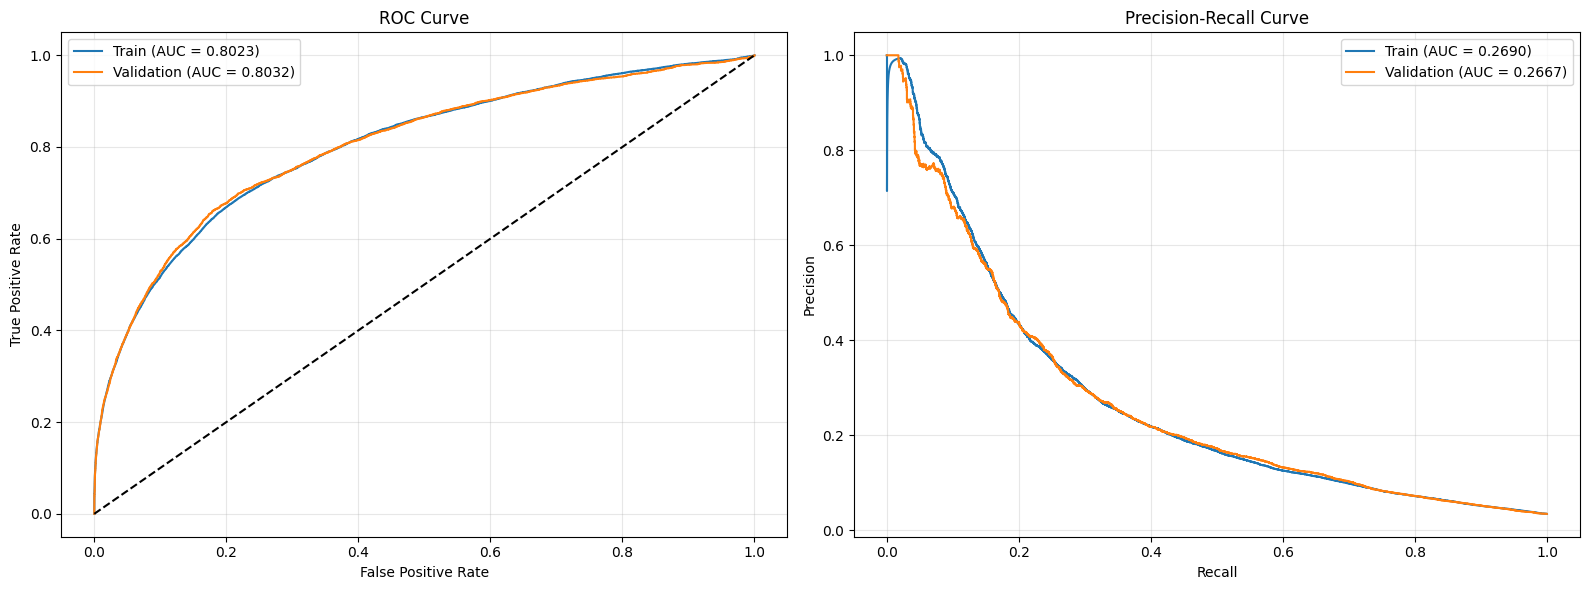


Top 10 Most Important Features:
   Feature  Coefficient   Absolute
0      C14   -12.291696  12.291696
7      C11     7.587768   7.587768
39      C4     5.731987   5.731987
6       C7    -3.464203   3.464203
15      C9     2.194940   2.194940
2       C2    -1.953462   1.953462
1       D9     1.321178   1.321178
5       C1     1.227699   1.227699
3       D8    -1.203550   1.203550
4       D4    -0.851225   0.851225


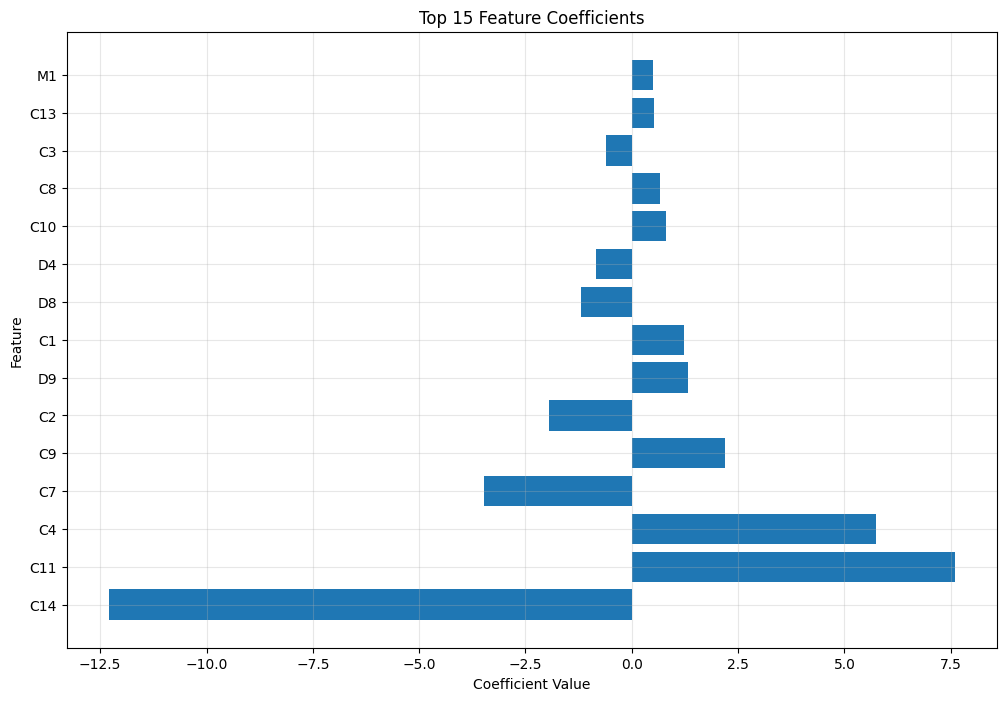

2025/04/29 18:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/29 18:33:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/29 18:33:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


threshold sensitivity analysis
Threshold=0.10, Precision: 0.2287, Recall: 0.3845, F1: 0.2868
Threshold=0.15, Precision: 0.3235, Recall: 0.2732, F1: 0.2962
Threshold=0.20, Precision: 0.4121, Recall: 0.2144, F1: 0.2820
Threshold=0.25, Precision: 0.5058, Recall: 0.1691, F1: 0.2535
Threshold=0.30, Precision: 0.5919, Recall: 0.1348, F1: 0.2196
Threshold=0.35, Precision: 0.6579, Recall: 0.1084, F1: 0.1861
Threshold=0.40, Precision: 0.7332, Recall: 0.0871, F1: 0.1557
Threshold=0.45, Precision: 0.7600, Recall: 0.0736, F1: 0.1341
Threshold=0.50, Precision: 0.7622, Recall: 0.0605, F1: 0.1121
Threshold=0.55, Precision: 0.7698, Recall: 0.0518, F1: 0.0970
Threshold=0.60, Precision: 0.7795, Recall: 0.0479, F1: 0.0903
Threshold=0.65, Precision: 0.8037, Recall: 0.0426, F1: 0.0809
Threshold=0.70, Precision: 0.8615, Recall: 0.0406, F1: 0.0776
Threshold=0.75, Precision: 0.8927, Recall: 0.0382, F1: 0.0733
Threshold=0.80, Precision: 0.9051, Recall: 0.0346, F1: 0.0667
Threshold=0.85, Precision: 0.9065, Reca

In [145]:
plot_model_performance(
        best_model, 
        best_X_train_scaled, 
        y_train_model, 
        best_X_val_scaled, 
        y_val
)
    
coef_df = analyze_coefficients(best_model, X_train_selected.columns)
    
mlflow.sklearn.log_model(best_model, "best_logistic_regression_model")
mlflow.sklearn.log_model(best_scaler, "standard_scaler")
  
threshold_results = []
thresholds = np.arange(0.1, 1.0, 0.05)
 
print("threshold sensitivity analysis")    
for threshold in thresholds:
    y_val_pred_binary = (model.predict_proba(best_X_val_scaled)[:, 1] >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred_binary)
    recall = recall_score(y_val, y_val_pred_binary)
    f1 = f1_score(y_val, y_val_pred_binary)
        
    threshold_results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
    })
        
    print(f"Threshold={threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
threshold_df = pd.DataFrame(threshold_results)
best_threshold = threshold_df.loc[threshold_df['f1'].idxmax()]['threshold']
    
print(f"\nOptimal threshold (by F1 score): {best_threshold:.2f}")
mlflow.log_param("optimal_threshold", best_threshold)
    
final_metrics = print_model_metrics(
        best_model, 
        best_X_train_scaled, 
        y_train_model, 
        best_X_val_scaled, 
        y_val,
        threshold=best_threshold
)

In [146]:
#logging on mlflow

In [147]:
mlflow.log_param("best_C", best_c)
mlflow.log_metric("best_val_auc", best_auc)
    
print(f"Best C: {best_c}")
print(f"Best Validation AUC: {best_auc:.4f}")

Best C: 100
Best Validation AUC: 0.8032


In [148]:
scaler_final = StandardScaler()
X_train_selected_scaled = scaler_final.fit_transform(X_train_selected)
    
final_model = LogisticRegression(
        C=best_c,
        penalty='l2',
        solver='liblinear',
        max_iter=200,
        random_state=42)

In [149]:
final_model.fit(X_train_selected_scaled, y_train)
full_pipeline = Pipeline([
        ('scaler', scaler_final),
        ('model', final_model)
    ])

In [150]:
mlflow.sklearn.log_model(full_pipeline, "logistic_regression_pipeline")

2025/04/29 18:34:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [151]:
#registering the best model on mlflow
mlflow.register_model(
        "runs:/{}/logistic_regression_pipeline".format(mlflow.active_run().info.run_id),
        "LogisticRegression_Fraud_Detection"
    )

Registered model 'LogisticRegression_Fraud_Detection' already exists. Creating a new version of this model...
2025/04/29 18:34:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_Fraud_Detection, version 4
Created version '4' of model 'LogisticRegression_Fraud_Detection'.


<ModelVersion: aliases=[], creation_timestamp=1745951695816, current_stage='None', description='', last_updated_timestamp=1745951695816, name='LogisticRegression_Fraud_Detection', run_id='526725831dcd447bba00b0fa2e0954a1', run_link='', source='mlflow-artifacts:/8dc2236309c04f8a9a9f9d8e3a15b65e/526725831dcd447bba00b0fa2e0954a1/artifacts/logistic_regression_pipeline', status='READY', status_message=None, tags={}, user_id='', version='4'>